In [1]:
%pylab 
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, 
               vmin=0., vmax=0., cmap_name='viridis', 
               magnitude= False, lw=5, 
               pixels_per_node=31, x_name='X', 
               y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixels_per_node)), int(round(grid.number_of_cell_rows*pixels_per_node)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
mg = RasterModelGrid((25,25),500)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')

#set heads at edges
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.1*np.random.rand(mg.number_of_active_links)+0.1

rates = mg.add_zeros('link','diss__rates')

#code added for fsolve algorithm
#dhdx = mg.add_zeros('link', 'hydraulic_head_gradient')
#net_node_flux = mg.add_ones('node', 'net_node_flux')


pfn = PresFlowNetwork(mg, solutes=['Ca', 'PCO2'], 
                      transfer_func=calcite_diss_palmer_transfer,
                     transfer_func_link_variables = ['hydraulic__diameter','conduit__discharge'],
                     transfer_kwd_args = {'T_C':10.})
#Here need to set boundary conditions for transport calculation
#add input to node 310
Ca = mg.at_node['concentration__Ca']
PCO2 = mg.at_node['concentration__PCO2']

input_Q=.05
input_C = 0.001
input_idx = 30+250#11
mg.at_node['input__discharge'][input_idx] = input_Q
mg.at_node['Ca__inflow_conc'][input_idx] = input_C 
mg.at_node['PCO2__inflow_conc'][input_idx] = 0.05

Ca[mg.nodes_at_left_edge] = 0.0005
Ca[mg.nodes_at_right_edge] = 0.
Ca[mg.nodes_at_top_edge] = 0.
Ca[mg.nodes_at_bottom_edge] = 0.

PCO2[mg.nodes_at_left_edge] = 0.01
PCO2[mg.nodes_at_right_edge] = 0.
PCO2[mg.nodes_at_top_edge] = 0.
PCO2[mg.nodes_at_bottom_edge] = 0.




#mg.at_link['Ca__conc_in']

Number of links =  1200
Number of nodes =  625
Number of active links =  1058
Number of core nodes =  529


In [ ]:
nsteps = 10000
step_start=0
dt = 1. #yr
every = 10
fig1, axs = subplots(2,3,figsize=(9,10))
for step in arange(nsteps)+step_start:
    print("Step: ",step)
    pfn.run_one_step(transport=True)
    #Calculate change of conduit diameters
    ddh_dt = mg.at_link['diss__rates']*0.001*dt
    mg.at_link['hydraulic__diameter'] += ddh_dt#[mg.active_links]
    print("max ddh_dt = ",str(max(ddh_dt)))
    print("min ddh_dt = ",str(min(ddh_dt)))
    print("max d_h=",str(max(d_h)))
    #Reset boundary node values
    Ca[mg.nodes_at_left_edge] = 0.0005
    Ca[mg.nodes_at_right_edge] = 0.
    Ca[mg.nodes_at_top_edge] = 0.
    Ca[mg.nodes_at_bottom_edge] = 0.

    PCO2[mg.nodes_at_left_edge] = 0.01
    PCO2[mg.nodes_at_right_edge] = 0.
    PCO2[mg.nodes_at_top_edge] = 0.
    PCO2[mg.nodes_at_bottom_edge] = 0.

    if (step % every)==0: #make an animation frame
        subplot(3,2,1)
        imshow_grid_at_node(mg, h, var_name='Head ($m$)', cmap='viridis')
        subplot(3,2,2)
        plot_links(mg, 'conduit__discharge', magnitude=True, var_name='Discharge ($m^3/s$)', lw=9,use_PIL=True)
        subplot(3,2,3)
        plot_links(mg, 'hydraulic__diameter', var_name='Hydraulic diameter ($m$)', lw=9,use_PIL=True)
        subplot(3,2,4)#, position=[0.2,0.2,0.9,0.9])
        plot_links(mg, 'diss__rates', var_name='Dissolution rate ($mm/yr$)', lw=9,use_PIL=True)
        subplot(3,2,5)
        imshow_grid_at_node(mg, Ca, var_name='Calcium ($mol/L$)', cmap='viridis')        
        subplot(3,2,6)
        imshow_grid_at_node(mg, PCO2, var_name='PCO2 (atm)', cmap='viridis')        
        image_name = 'speleo_example/speleogenesis_output'+str(step).zfill(6)+'.png'
        subplots_adjust(wspace=0.3)
        savefig(image_name)
        fig1.clf()


Step:  0
Number of iterations = 1 tolerance = 0.125759081284  iteration time= 0.16797208786010742
Number of iterations = 2 tolerance = 0.0390624401327  iteration time= 0.16439080238342285
Number of iterations = 3 tolerance = 0.0195383288769  iteration time= 0.1560208797454834
Number of iterations = 4 tolerance = 0.00983828874694  iteration time= 0.16233396530151367
Number of iterations = 5 tolerance = 0.00512151396912  iteration time= 0.15436339378356934
Number of iterations = 6 tolerance = 0.00411908552274  iteration time= 0.16632509231567383
Number of iterations = 7 tolerance = 0.00315706005933  iteration time= 0.1559450626373291
Number of iterations = 8 tolerance = 0.00128898765458  iteration time= 0.16383743286132812
Number of iterations = 9 tolerance = 0.000486127519897  iteration time= 0.154571533203125
Number of iterations = 10 tolerance = 0.00031674387152  iteration time= 0.16621661186218262
Number of iterations = 11 tolerance = 8.46950158698e-05  iteration time= 0.173543930053

Number of iterations = 2 tolerance = 1.8242726352e-06  iteration time= 0.1625053882598877
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.231512697818
Step:  28
Number of iterations = 1 tolerance = 9.62091216822e-05  iteration time= 0.17342686653137207
Number of iterations = 2 tolerance = 2.60591139124e-06  iteration time= 0.16656041145324707
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.232690157706
Step:  29
Number of iterations = 1 tolerance = 0.000101531649743  iteration time= 0.15907621383666992
Number of iterations = 2 tolerance = 2.99524018974e-06  iteration time= 0.16221117973327637
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.233867617594
Step:  30
Number of iterations = 1 tolerance = 9.13591206515e-05  iteration time= 0.1819441318511963
Number of iterations = 2 tolerance = 2.40471699033e-06  iteration time= 0.1675584316253662
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.235045077482
Step:  31
Number of iterations = 1 tol

max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.265659034569
Step:  57
Number of iterations = 1 tolerance = 9.10295419431e-05  iteration time= 0.16019201278686523
Number of iterations = 2 tolerance = 4.03249110206e-06  iteration time= 0.16098618507385254
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.266836494457
Step:  58
Number of iterations = 1 tolerance = 9.47552616589e-05  iteration time= 0.1528456211090088
Number of iterations = 2 tolerance = 1.31552969782e-06  iteration time= 0.1590273380279541
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.268013954345
Step:  59
Number of iterations = 1 tolerance = 9.84891379788e-05  iteration time= 0.16819453239440918
Number of iterations = 2 tolerance = 1.4596154368e-06  iteration time= 0.16147303581237793
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.269191414233
Step:  60
Number of iterations = 1 tolerance = 0.000102532261755  iteration time= 0.156036376953125
Number of iterations = 2 tole

max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.302160291096
Step:  88
Number of iterations = 1 tolerance = 7.54436749159e-05  iteration time= 0.15662455558776855
Number of iterations = 2 tolerance = 2.61506260547e-06  iteration time= 0.15836048126220703
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.303337750984
Step:  89
Number of iterations = 1 tolerance = 7.25551334895e-05  iteration time= 0.15729951858520508
Number of iterations = 2 tolerance = 1.77324469589e-06  iteration time= 0.16007733345031738
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.304515210872
Step:  90
Number of iterations = 1 tolerance = 7.14304316186e-05  iteration time= 0.1580979824066162
Number of iterations = 2 tolerance = 1.22341494669e-06  iteration time= 0.16021323204040527
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.30569267076
Step:  91
Number of iterations = 1 tolerance = 7.02855655193e-05  iteration time= 0.15351581573486328
Number of iterations = 2 t

max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.338661547623
Step:  119
Number of iterations = 1 tolerance = 0.000105296379742  iteration time= 0.14835524559020996
Number of iterations = 2 tolerance = 9.74928937743e-07  iteration time= 0.15413260459899902
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.339839007511
Step:  120
Number of iterations = 1 tolerance = 0.000102488486039  iteration time= 0.15689468383789062
Number of iterations = 2 tolerance = 8.09985349417e-07  iteration time= 0.15572547912597656
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.341016467399
Step:  121
Number of iterations = 1 tolerance = 9.99016830282e-05  iteration time= 0.14725565910339355
Number of iterations = 2 tolerance = 7.82413854167e-07  iteration time= 0.15340065956115723
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.342193927287
Step:  122
Number of iterations = 1 tolerance = 9.75685854665e-05  iteration time= 0.16324305534362793
Number of iterations

Number of iterations = 2 tolerance = 2.42659593355e-07  iteration time= 0.15267181396484375
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.37516280415
Step:  150
Number of iterations = 1 tolerance = 0.000114271441903  iteration time= 0.15337824821472168
Number of iterations = 2 tolerance = 2.4038574549e-07  iteration time= 0.1537787914276123
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.376340264038
Step:  151
Number of iterations = 1 tolerance = 0.000115507955465  iteration time= 0.14736652374267578
Number of iterations = 2 tolerance = 2.33680757332e-07  iteration time= 0.15101885795593262
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.377517723926
Step:  152
Number of iterations = 1 tolerance = 0.000116759342312  iteration time= 0.15679693222045898
Number of iterations = 2 tolerance = 2.27966790242e-07  iteration time= 0.15077662467956543
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.378695183814
Step:  153
Number of iterations = 

Number of iterations = 2 tolerance = 4.23200192175e-07  iteration time= 0.15974116325378418
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.411664060677
Step:  181
Number of iterations = 1 tolerance = 0.000170433045718  iteration time= 0.14911723136901855
Number of iterations = 2 tolerance = 4.52944688312e-07  iteration time= 0.15387845039367676
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.412841520565
Step:  182
Number of iterations = 1 tolerance = 0.000173228253703  iteration time= 0.1524057388305664
Number of iterations = 2 tolerance = 4.84671834091e-07  iteration time= 0.15433740615844727
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.414018980453
Step:  183
Number of iterations = 1 tolerance = 0.000176132505315  iteration time= 0.1593008041381836
Number of iterations = 2 tolerance = 5.20033465374e-07  iteration time= 0.15257811546325684
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.415196440341
Step:  184
Number of iterations =

Number of iterations = 2 tolerance = 7.02397964775e-07  iteration time= 0.15551519393920898
max ddh_dt =  0.00113429727341
min ddh_dt =  0.0
max d_h= 0.446157342863
Step:  212
Number of iterations = 1 tolerance = 0.000200582710517  iteration time= 0.1609938144683838
Number of iterations = 2 tolerance = 6.4909225012e-07  iteration time= 0.1632249355316162
max ddh_dt =  0.00113213153213
min ddh_dt =  0.0
max d_h= 0.447289474395
Step:  213
Number of iterations = 1 tolerance = 0.000198897896167  iteration time= 0.15348505973815918
Number of iterations = 2 tolerance = 6.0234457729e-07  iteration time= 0.154127836227417
max ddh_dt =  0.00112999648545
min ddh_dt =  0.0
max d_h= 0.448419470881
Step:  214
Number of iterations = 1 tolerance = 0.000197248644183  iteration time= 0.16152286529541016
Number of iterations = 2 tolerance = 5.57996412911e-07  iteration time= 0.16054415702819824
max ddh_dt =  0.00112789133615
min ddh_dt =  0.0
max d_h= 0.449547362217
Step:  215
Number of iterations = 1 t

Number of iterations = 2 tolerance = 5.51631770496e-07  iteration time= 0.15556597709655762
max ddh_dt =  0.00107750307113
min ddh_dt =  0.0
max d_h= 0.480331964684
Step:  243
Number of iterations = 1 tolerance = 0.000146180212023  iteration time= 0.15549993515014648
Number of iterations = 2 tolerance = 5.30742561824e-07  iteration time= 0.16627216339111328
max ddh_dt =  0.00107610617402
min ddh_dt =  0.0
max d_h= 0.481408070858
Step:  244
Number of iterations = 1 tolerance = 0.000144995533023  iteration time= 0.1552128791809082
Number of iterations = 2 tolerance = 5.11206709004e-07  iteration time= 0.16489410400390625
max ddh_dt =  0.00107472685147
min ddh_dt =  0.0
max d_h= 0.48248279771
Step:  245
Number of iterations = 1 tolerance = 0.000143845149122  iteration time= 0.1682567596435547
Number of iterations = 2 tolerance = 4.92899956301e-07  iteration time= 0.15370821952819824
max ddh_dt =  0.00107336315446
min ddh_dt =  0.0
max d_h= 0.483556160864
Step:  246
Number of iterations = 

Number of iterations = 2 tolerance = 1.91680346856e-07  iteration time= 0.15167999267578125
max ddh_dt =  0.00103777920415
min ddh_dt =  0.0
max d_h= 0.513095170716
Step:  274
Number of iterations = 1 tolerance = 0.00012069817415  iteration time= 0.1504807472229004
Number of iterations = 2 tolerance = 1.89238529684e-07  iteration time= 0.15357279777526855
max ddh_dt =  0.00103668517027
min ddh_dt =  0.0
max d_h= 0.514131855886
Step:  275
Number of iterations = 1 tolerance = 0.000120073804833  iteration time= 0.15051913261413574
Number of iterations = 2 tolerance = 1.8690294529e-07  iteration time= 0.15376019477844238
max ddh_dt =  0.00103560036112
min ddh_dt =  0.0
max d_h= 0.515167456247
Step:  276
Number of iterations = 1 tolerance = 0.000119462076783  iteration time= 0.1494276523590088
Number of iterations = 2 tolerance = 1.84654549692e-07  iteration time= 0.1495201587677002
max ddh_dt =  0.00103452459025
min ddh_dt =  0.0
max d_h= 0.516201980837
Step:  277
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.36484360808e-07  iteration time= 0.15642094612121582
max ddh_dt =  0.00100759551618
min ddh_dt =  0.0
max d_h= 0.544748532081
Step:  305
Number of iterations = 1 tolerance = 0.000122842705001  iteration time= 0.15104913711547852
Number of iterations = 2 tolerance = 1.35271879735e-07  iteration time= 0.1565840244293213
max ddh_dt =  0.00100678898554
min ddh_dt =  0.0
max d_h= 0.545755321067
Step:  306
Number of iterations = 1 tolerance = 0.000123087773364  iteration time= 0.15035152435302734
Number of iterations = 2 tolerance = 1.34103293879e-07  iteration time= 0.15557408332824707
max ddh_dt =  0.00100598730412
min ddh_dt =  0.0
max d_h= 0.546761308371
Step:  307
Number of iterations = 1 tolerance = 0.000123335390878  iteration time= 0.15068292617797852
Number of iterations = 2 tolerance = 1.32953411814e-07  iteration time= 0.1565697193145752
max ddh_dt =  0.00100519038542
min ddh_dt =  0.0
max d_h= 0.547766498756
Step:  308
Number of iterations =

Number of iterations = 2 tolerance = 1.08995723226e-07  iteration time= 0.15804767608642578
max ddh_dt =  0.000984550778136
min ddh_dt =  0.0
max d_h= 0.575605579235
Step:  336
Number of iterations = 1 tolerance = 0.000131308357417  iteration time= 0.1528339385986328
Number of iterations = 2 tolerance = 1.08175246579e-07  iteration time= 0.15476155281066895
max ddh_dt =  0.000983865148205
min ddh_dt =  0.0
max d_h= 0.576589444383
Step:  337
Number of iterations = 1 tolerance = 0.000131614284423  iteration time= 0.15853667259216309
Number of iterations = 2 tolerance = 1.07365093089e-07  iteration time= 0.1563875675201416
max ddh_dt =  0.000983182580586
min ddh_dt =  0.0
max d_h= 0.577572626964
Step:  338
Number of iterations = 1 tolerance = 0.000131927525691  iteration time= 0.15198731422424316
Number of iterations = 2 tolerance = 1.06516326789e-07  iteration time= 0.15573763847351074
max ddh_dt =  0.000982502998786
min ddh_dt =  0.0
max d_h= 0.578555129963
Step:  339
Number of iteratio

Number of iterations = 2 tolerance = 2.00576296954e-07  iteration time= 0.15779495239257812
max ddh_dt =  0.000964437860396
min ddh_dt =  0.0
max d_h= 0.605799313328
Step:  367
Number of iterations = 1 tolerance = 0.000138201835686  iteration time= 0.15029501914978027
Number of iterations = 2 tolerance = 1.93259547814e-07  iteration time= 0.15349125862121582
max ddh_dt =  0.000963822504966
min ddh_dt =  0.0
max d_h= 0.606763135833
Step:  368
Number of iterations = 1 tolerance = 0.000138413481982  iteration time= 0.15261411666870117
Number of iterations = 2 tolerance = 1.92100920817e-07  iteration time= 0.15108919143676758
max ddh_dt =  0.000963208960097
min ddh_dt =  0.0
max d_h= 0.607726344793
Step:  369
Number of iterations = 1 tolerance = 0.000138625346493  iteration time= 0.1507711410522461
Number of iterations = 2 tolerance = 1.90955788072e-07  iteration time= 0.15072393417358398
max ddh_dt =  0.000962597208855
min ddh_dt =  0.0
max d_h= 0.608688942002
Step:  370
Number of iterati

Number of iterations = 2 tolerance = 1.53001776567e-07  iteration time= 0.15110087394714355
max ddh_dt =  0.000946091893168
min ddh_dt =  0.0
max d_h= 0.635399675397
Step:  398
Number of iterations = 1 tolerance = 0.00014533479852  iteration time= 0.1503438949584961
Number of iterations = 2 tolerance = 1.52184605132e-07  iteration time= 0.15259289741516113
max ddh_dt =  0.000945522711796
min ddh_dt =  0.0
max d_h= 0.636345198109
Step:  399
Number of iterations = 1 tolerance = 0.000145681477992  iteration time= 0.1506786346435547
Number of iterations = 2 tolerance = 1.51375760584e-07  iteration time= 0.15433144569396973
max ddh_dt =  0.000944954816134
min ddh_dt =  0.0
max d_h= 0.637290152925
Step:  400
Number of iterations = 1 tolerance = 0.000146032969846  iteration time= 0.15232586860656738
Number of iterations = 2 tolerance = 1.50578696302e-07  iteration time= 0.15280389785766602
max ddh_dt =  0.000944388171549
min ddh_dt =  0.0
max d_h= 0.638234541097
Step:  401
Number of iteration

Number of iterations = 2 tolerance = 1.25816163631e-07  iteration time= 0.15446162223815918
max ddh_dt =  0.00092900573118
min ddh_dt =  0.0
max d_h= 0.664452307211
Step:  429
Number of iterations = 1 tolerance = 0.000156134468271  iteration time= 0.1502094268798828
Number of iterations = 2 tolerance = 1.25357018326e-07  iteration time= 0.15640711784362793
max ddh_dt =  0.000928471974641
min ddh_dt =  0.0
max d_h= 0.665380779185
Step:  430
Number of iterations = 1 tolerance = 0.000156490859542  iteration time= 0.16130924224853516
Number of iterations = 2 tolerance = 1.24903264475e-07  iteration time= 0.15318965911865234
max ddh_dt =  0.000927939188345
min ddh_dt =  0.0
max d_h= 0.666308718374
Step:  431
Number of iterations = 1 tolerance = 0.000156847705931  iteration time= 0.14797616004943848
Number of iterations = 2 tolerance = 1.24464013649e-07  iteration time= 0.15116262435913086
max ddh_dt =  0.000927407365377
min ddh_dt =  0.0
max d_h= 0.667236125739
Step:  432
Number of iteratio

In [21]:
ddh_dt.shape
print(mg.active_links.shape)

(1058,)


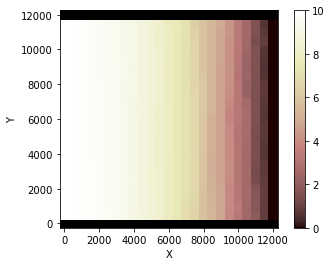

In [6]:
figure()
imshow_grid_at_node(mg, h)


In [14]:
figure()
plot_links(mg, 'conduit__discharge', use_PIL=True, )

figure()
plot_links(mg, 'diss__rates', use_PIL=True)

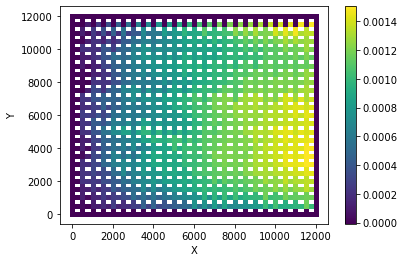

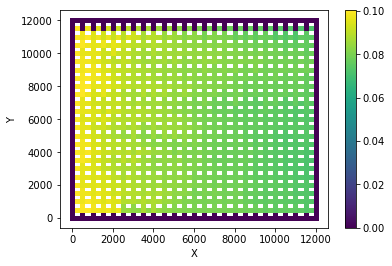

In [8]:
plot_links(mg, 'Ca__conc_in', use_PIL=False)
figure()
plot_links(mg, 'PCO2__conc_in', use_PIL=False)


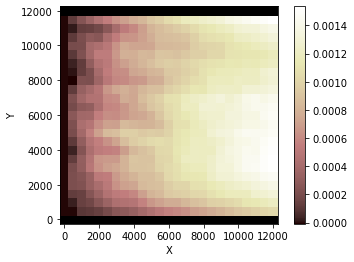

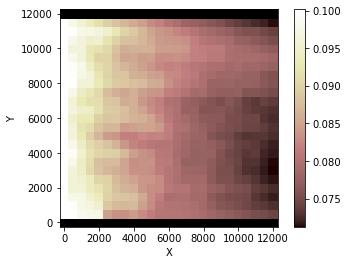

In [9]:
imshow_grid_at_node(mg, Ca)
figure()
imshow_grid_at_node(mg, PCO2)


In [5]:
#mg.at_node['concentration__Ca']
mg.at_link['diss__rates']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

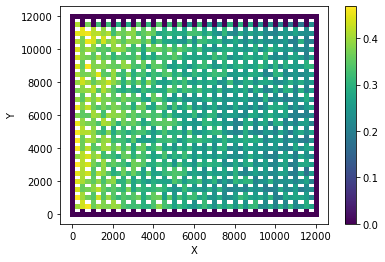

In [10]:
plot_links(mg, 'hydraulic__diameter', use_PIL=False)

In [7]:
this_node_links = mg.links_at_node[575]
this_node_dirs = mg.active_link_dirs_at_node[575]
print (this_node_dirs)
print(this_node_links)
node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
node_inflow_links = this_node_links[node_Qs>0]
node_outflow_links = this_node_links[node_Qs<0]
print(len(node_inflow_links))
print(node_outflow_links)

total_inflow = np.abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                            mg.at_node['input__discharge'][575]
print(total_inflow)


sum(np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['Ca__conc_out'][node_inflow_links])

[-1  0  0  0]
[1127 1151   -1 1102]
0
[1127]
0.0


0.0

In [6]:
mg.length_of_link

array([ 500.,  500.,  500., ...,  500.,  500.,  500.])

In [15]:
def test(a=1,b=2,c=3, d=None, e=0):
    return a*b*c*d*e

t1={'a':5,'b':42,'c':3}
t2 = {'d':4,'e':5}
test(**t2, **t1)

#test != None

12600

In [6]:
from olm.calcite import palmerRate, concCaEqFromPCO2

In [8]:
concCaEqFromPCO2(0.05,T_C=15.)

0.0033976549243382144

In [10]:
palmerRate(25., [0.005,0.01], [0.5,0.75])
concCaEqFromPCO2(array([0.01,0.02]), T_C=array([15.,25.]))

array([ 0.00190117,  0.00205579])

In [11]:
#Get index of nodes sorted by descending head
idx = np.argsort(-h)#Sort on negative to get descending order sort
#Loop through nodes from highest to lowest hydraulic head
for node_idx in idx:
    #Determine link indicies and directions for this node
    this_node_links = mg.links_at_node[node_idx]
    this_node_dirs = mg.active_link_dirs_at_node[node_idx]

    #Determine which links have inflow and outflow to/from node
    node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
    node_inflow_links = this_node_links[node_Qs>0]
    node_outflow_links = this_node_links[node_Qs<0]

    #Calculate node concentration from inflows (including boundary inflows)
    total_inflow = abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                    mg.at_node['input__discharge'][node_idx]

    #avoid cases with no inflow (e.g. closed boundaries)
    if total_inflow !=0:
        #Will need a loop here to loop through solutes
        conc_mult = np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['conduit__conc_out'][node_inflow_links]
        input_conc_mult = mg.at_node['input__discharge'][node_idx]*mg.at_node['input__concentration'][node_idx]
        conc_node = (conc_mult.sum() + input_conc_mult)/total_inflow
        C[node_idx] = conc_node
        
        #set outflow link concentrations
        mg.at_link['conduit__conc_in'][node_outflow_links] = conc_node
        
        #Calculate output link concentrations (for now conservative)
        mg.at_link['conduit__conc_out'][node_outflow_links] = mg.at_link['conduit__conc_in'][node_outflow_links]




FieldError: conduit__conc_out